In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-11-02 08:33:45.875930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nflx = yf.download('NFLX', start='2017-10-28', end='2022-10-28')
nflx


[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-10-30  199.619995  201.100006  197.070007  198.369995  198.369995   
2017-10-31  198.210007  198.589996  195.220001  196.429993  196.429993   
2017-11-01  197.240005  199.199997  196.000000  198.000000  198.000000   
2017-11-02  197.449997  199.440002  197.089996  199.320007  199.320007   
2017-11-03  199.800003  200.550003  197.990005  200.009995  200.009995   
...                ...         ...         ...         ...         ...   
2022-10-21  268.950012  290.750000  265.679993  289.570007  289.570007   
2022-10-24  290.230011  290.489990  280.359985  282.450012  282.450012   
2022-10-25  286.950012  297.589996  285.549988  291.019989  291.019989   
2022-10-26  290.040009  305.630005  288.040009  298.619995  298.619995   
2022-10-27  298.329987  305.209991  294.779999  296.940002  296.940002   

              Volume  
Date                  
2017-10-30   5439600  
2017-10-31   5518600  
2017-11-01   5017400  
2017-11-02   3606300  
2017-11-03   3678800  
...              ...  
2022-10-21  24862700  
2022-10-24  13326400  
2022-10-25  15100700  
2022-10-26  15714100  
2022-10-27  14612600  

[1258 rows x 6 columns]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

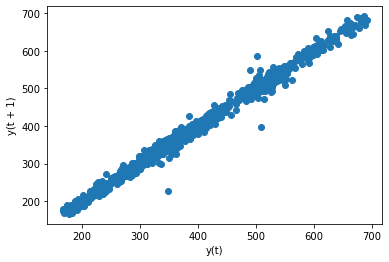

In [3]:
lag_plot(nflx.Close)

mean : 384.3837834708452


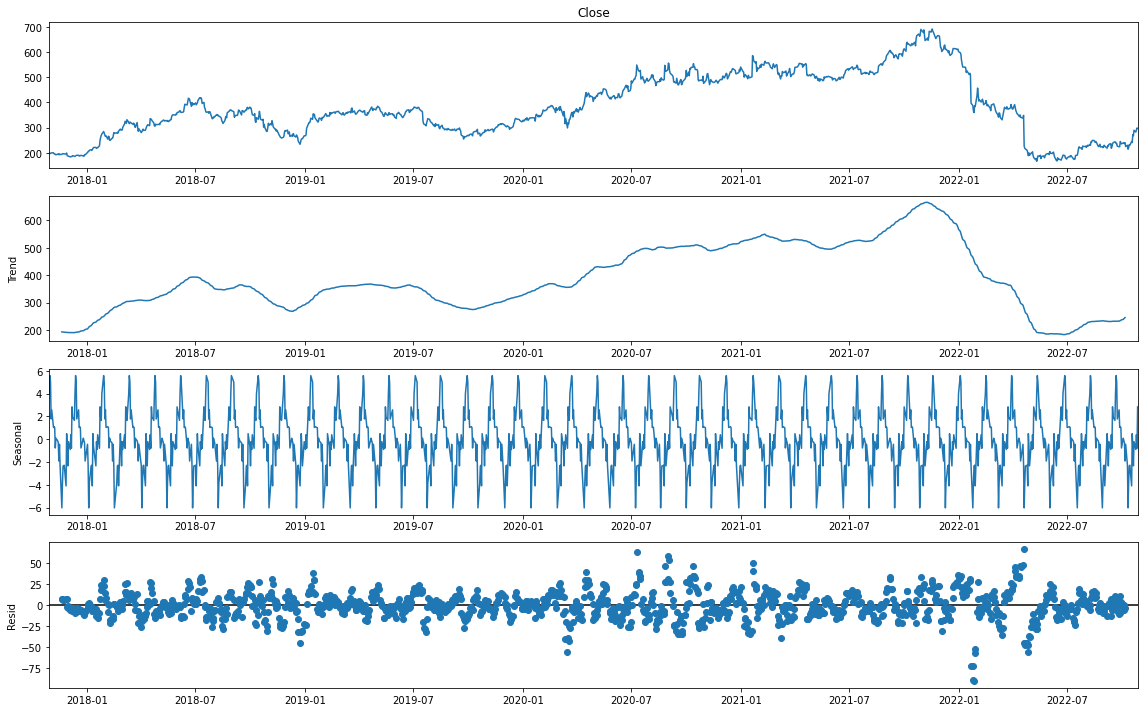

In [4]:
import statsmodels.api as sm
print('mean :' , nflx.Close.mean())
res = sm.tsa.seasonal_decompose(nflx.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

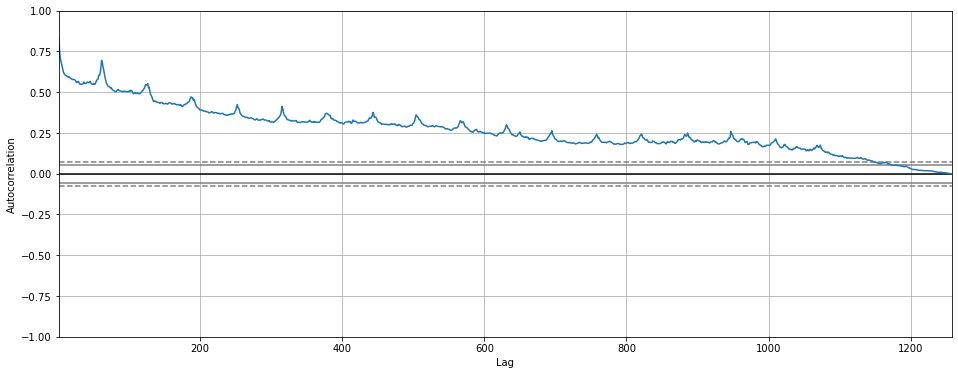

In [5]:
plt.figure(figsize=(16,6))
autocorrelation_plot(nflx)

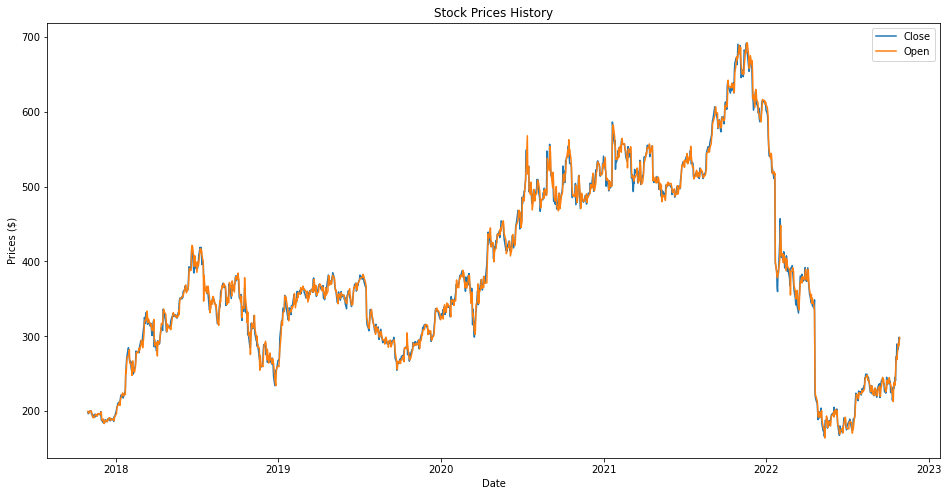

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(nflx['Close'], label='Close')
plt.plot(nflx['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

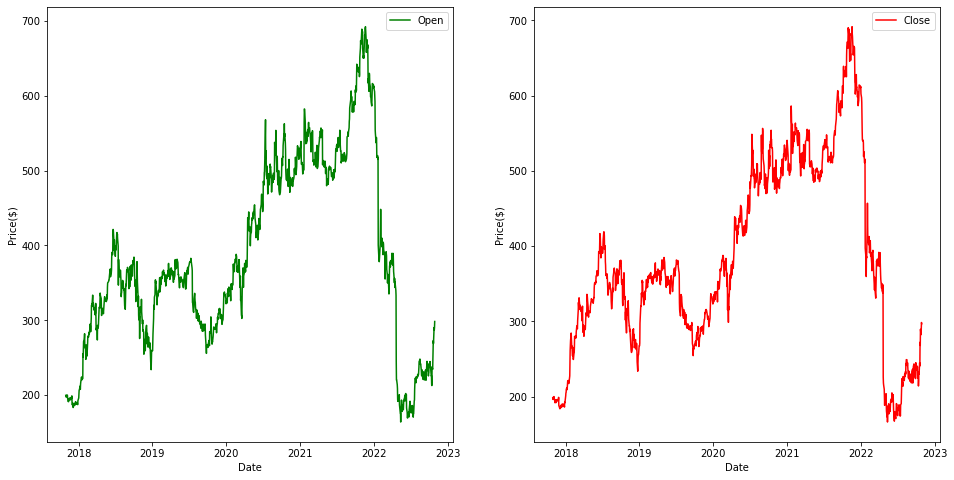

In [7]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(nflx['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(nflx['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [8]:
close_prices = nflx['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(750, len(train_data)):
    x_train.append(train_data[i-750:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-750: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(750, len(test_data)):
    x_test.append(test_data[i-750:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(layers.Dense(100))
model.add(layers.Dense(75))
model.add(layers.Dense(50))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



2022-11-02 08:33:54.122904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 750, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 750, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 750, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 750, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 750, 100)          80400     
                                                                 
 dropout_2 (Dropout)         (None, 750, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [10]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 64, epochs=200)

Epoch 1/200
5/5 [==============================] - 17s 2s/step - loss: 0.1813
Epoch 2/200
5/5 [==============================] - 9s 2s/step - loss: 0.0187
Epoch 3/200
5/5 [==============================] - 10s 2s/step - loss: 0.0112
Epoch 4/200
5/5 [==============================] - 10s 2s/step - loss: 0.0077
Epoch 5/200
5/5 [==============================] - 9s 2s/step - loss: 0.0113
Epoch 6/200
5/5 [==============================] - 9s 2s/step - loss: 0.0096
Epoch 7/200
5/5 [==============================] - 10s 2s/step - loss: 0.0089
Epoch 8/200
5/5 [==============================] - 10s 2s/step - loss: 0.0115
Epoch 9/200
5/5 [==============================] - 9s 2s/step - loss: 0.0070
Epoch 10/200
5/5 [==============================] - 10s 2s/step - loss: 0.0062
Epoch 11/200
5/5 [==============================] - 9s 2s/step - loss: 0.0057
Epoch 12/200
5/5 [==============================] - 9s 2s/step - loss: 0.0075
Epoch 13/200
5/5 [==============================] - 10s 2s/step - l

5/5 [==============================] - 9s 2s/step - loss: 0.0022
Epoch 106/200
5/5 [==============================] - 9s 2s/step - loss: 0.0022
Epoch 107/200
5/5 [==============================] - 9s 2s/step - loss: 0.0026
Epoch 108/200
5/5 [==============================] - 9s 2s/step - loss: 0.0024
Epoch 109/200
5/5 [==============================] - 9s 2s/step - loss: 0.0023
Epoch 110/200
5/5 [==============================] - 9s 2s/step - loss: 0.0025
Epoch 111/200
5/5 [==============================] - 9s 2s/step - loss: 0.0046
Epoch 112/200
5/5 [==============================] - 9s 2s/step - loss: 0.0036
Epoch 113/200
5/5 [==============================] - 9s 2s/step - loss: 0.0038
Epoch 114/200
5/5 [==============================] - 9s 2s/step - loss: 0.0046
Epoch 115/200
5/5 [==============================] - 9s 2s/step - loss: 0.0050
Epoch 116/200
5/5 [==============================] - 9s 2s/step - loss: 0.0029
Epoch 117/200
5/5 [==============================] - 9s 2s/step - 

In [11]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 6s 478ms/step
CPU times: user 11.2 s, sys: 3.41 s, total: 14.6 s
Wall time: 6.17 s


64.37752596790573

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


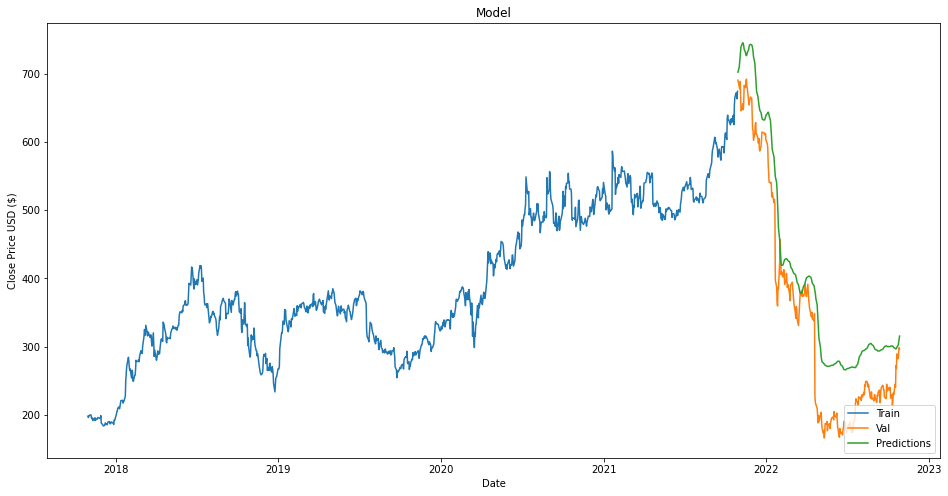

CPU times: user 636 ms, sys: 458 ms, total: 1.09 s
Wall time: 1.23 s


In [12]:
%%time
data = nflx.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

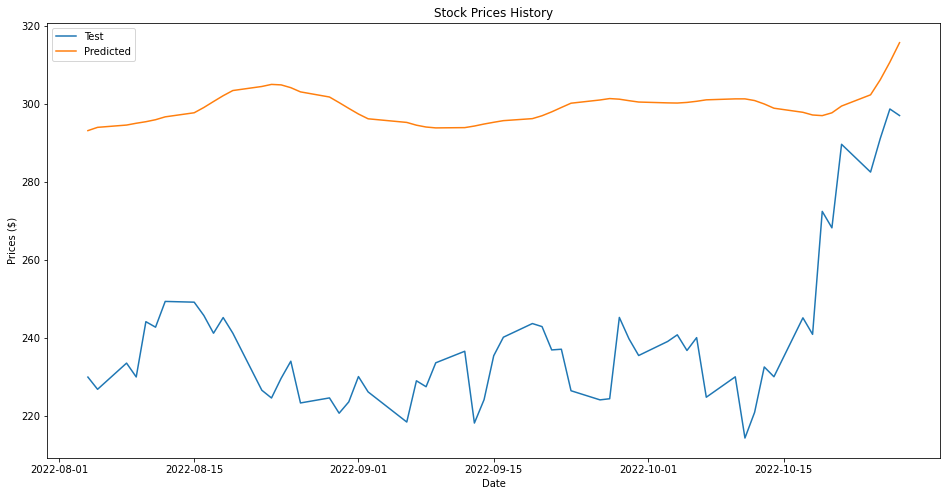

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(validation['Close'].iloc[-60:], label='Test')
plt.plot(validation['Predictions'].iloc[-60:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

In [20]:
from pandas import Timestamp
start = Timestamp('2022-10-27')
end = Timestamp('2024-11-14')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

Value
Date             
2022-10-27      0
2022-10-28      0
2022-10-29      0
2022-10-30      0
2022-10-31      0
...           ...
2024-11-10      0
2024-11-11      0
2024-11-12      0
2024-11-13      0
2024-11-14      0

[750 rows x 1 columns]

In [21]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

24/24 [==============================] - 0s 3ms/step


In [23]:
futurepredictions[0]

array([506.08588], dtype=float32)

In [24]:
%%time

model2 = Sequential()

model2.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.summary()

model2.compile(optimizer='adam',loss='mean_squared_error')
model2.fit(x_train,y_train,epochs=100,batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 750, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 750, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 750, 50)           20200     
                                                                 
 dropout_5 (Dropout)         (None, 750, 50)           0         
                                                                 
 lstm_6 (LSTM)               (None, 750, 50)           20200     
                                                                 
 dropout_6 (Dropout)         (None, 750, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

9/9 [==============================] - 7s 829ms/step - loss: 0.0057
Epoch 83/100
9/9 [==============================] - 8s 889ms/step - loss: 0.0064
Epoch 84/100
9/9 [==============================] - 9s 963ms/step - loss: 0.0094
Epoch 85/100
9/9 [==============================] - 11s 1s/step - loss: 0.0080
Epoch 86/100
9/9 [==============================] - 12s 1s/step - loss: 0.0066
Epoch 87/100
9/9 [==============================] - 12s 1s/step - loss: 0.0066
Epoch 88/100
9/9 [==============================] - 13s 1s/step - loss: 0.0079
Epoch 89/100
9/9 [==============================] - 12s 1s/step - loss: 0.0067
Epoch 90/100
9/9 [==============================] - 13s 1s/step - loss: 0.0064
Epoch 91/100
9/9 [==============================] - 12s 1s/step - loss: 0.0075
Epoch 92/100
9/9 [==============================] - 12s 1s/step - loss: 0.0073
Epoch 93/100
9/9 [==============================] - 13s 1s/step - loss: 0.0054
Epoch 94/100
9/9 [==============================] - 12s 1s/

In [25]:
%%time
predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2)
rmse2 = np.sqrt(np.mean(predictions2 - y_test)**2)
rmse2

8/8 [==============================] - 3s 188ms/step
CPU times: user 3.85 s, sys: 501 ms, total: 4.35 s
Wall time: 3.27 s


35.8997917023313